# AWS Model

This notebook involves building an ARIMA model to forecast stock prices (AAPL) and evaluate the model's performance using various metrics.

It includes:
- Splitting the dataset into training and testing sets
- Fitting the ARIMA model
- Making predictions
- Calculating key performance metrics such as Mean Squared Error (MSE), R-squared, and Adjusted R-squared

Results and metrics are saved to both text and CSV files for further analysis.

_This notebook was created by Huma Raja Liaqat_


### Importing Libraries for Data Analysis and Modeling

In this section, we import the necessary libraries and set up our environment to perform time series analysis and modeling.

1. **Disabling Warnings**:
   - We use the `warnings.filterwarnings('ignore')` function to suppress unnecessary warnings during analysis to keep the output clean.
2. **Bucketname**:
   - `sagemakerbuckethuma` is the name of bucket where the cleaned data is saved to train the model.


In [42]:
import warnings
warnings.filterwarnings('ignore')
bucket_name='sagemakerbuckethuma'

import boto3
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

### Interacting with AWS S3 using `boto3`

In this section, we will set up an Amazon S3 connection and perform some basic operations such as listing files in a bucket and copying files from S3 to the local system.

1. **Establishing a Session**:
   - Using `boto3.Session()`, we create a session to interact with AWS services, specifically S3. The session can be used to authenticate and make API calls.


In [43]:
s3_resource = boto3.Session().resource('s3')

session = boto3.Session()

!aws s3 ls s3://sagemakerbuckethuma/
!aws s3 cp s3://sagemakerbuckethuma/AAPL_cleaned_data.csv ./my_data/AAPL_cleaned_data.csv
!aws s3 cp s3://sagemakerbuckethuma/MSFT_cleaned_data.csv ./my_data/MSFT_cleaned_data.csv

[11/27/24 17:05:57] INFO     Found credentials from IAM Role:                                   ]8;id=827991;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=283725;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

2024-11-27 15:54:52     983252 AAPL_cleaned_data.csv
2024-11-27 15:54:53     793698 MSFT_cleaned_data.csv
download: s3://sagemakerbuckethuma/AAPL_cleaned_data.csv to my_data/AAPL_cleaned_data.csv
download: s3://sagemakerbuckethuma/MSFT_cleaned_data.csv to my_data/MSFT_cleaned_data.csv


### ARIMA Model for Apple Stock Price Prediction

This section demonstrates how to apply the ARIMA (AutoRegressive Integrated Moving Average) model to predict future values of Apple's stock price based on historical data. We will first load the data, process it, and then use the ARIMA model for time series forecasting.

   - We load the cleaned Apple stock data from a CSV file (`AAPL_cleaned_data.csv`), set the date column as the index, and parse it as `datetime` for better handling.

The code is preparing time series data for forecasting using the ARIMA model. It:

1. Converts the index to datetime for proper time-based analysis.
2. Extracts the target variable (close_aapl), which represents Apple stock's closing prices.
3. Resamples the data to an annual frequency.
4. Splits the data into training and test sets.
5. Defines and fits an ARIMA model on the training data to learn the patterns in the stock price for future forecasting.


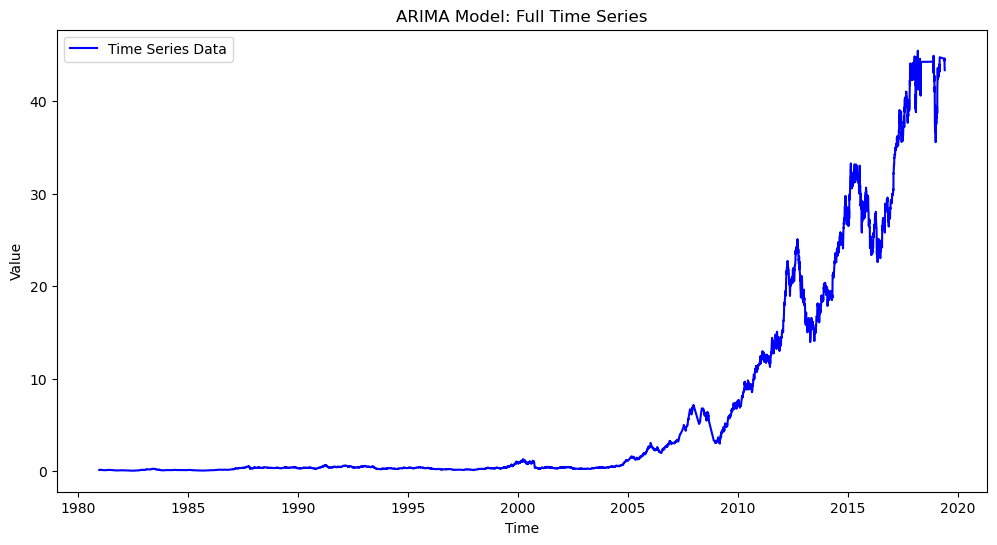

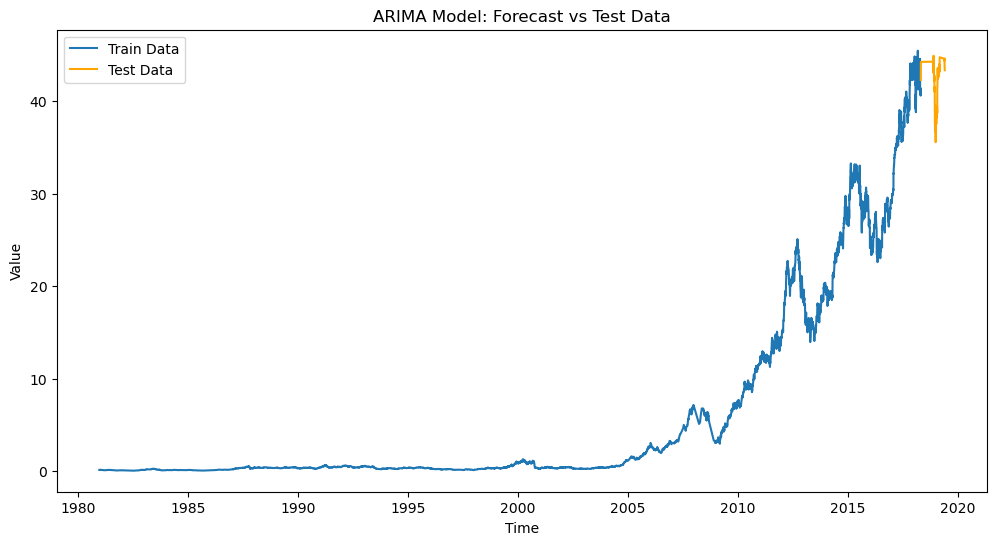

In [44]:
file_path = "my_data/AAPL_cleaned_data.csv"
data = pd.read_csv(file_path, parse_dates=["date"], index_col="date")

data.index = pd.to_datetime(data.index)

time_series = data["close_aapl"]
data = data.asfreq('A') 
train = time_series[:-80]
test = time_series[-80:]

model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()

plt.figure(figsize=(12, 6))
plt.plot(time_series, label="Time Series Data", linestyle='-', color='blue')  # Ensure solid line
plt.title("ARIMA Model: Full Time Series")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(train, label="Train Data")
plt.plot(test, label="Test Data", color="orange")
plt.title("ARIMA Model: Forecast vs Test Data")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()

1. **Forecasting**:
   - `predicted_values = model_fit.forecast(steps=len(test))`: Forecasts future values for the test set using the trained ARIMA model.

2. **Evaluating Model Performance**:
   - `aapl = mean_squared_error(test, predicted_values)`: Calculates the Mean Squared Error (MSE) between the actual test values and the predicted values.
   - `r2 = r2_score(test, predicted_values)`: Computes the R-squared value, indicating how well the model fits the data.
   - `adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)`: Adjusts the R-squared for the number of predictors (degrees of freedom) to avoid overfitting.

3. **Saving Results**:
   - `results_df`: A DataFrame with actual vs predicted values for the test set.
   - `metrics_df`: A DataFrame containing the evaluation metrics (MSE, R-squared, Adjusted R-squared).
   - The results are saved to `ARIMA_AAPL_results.csv` for future reference.


In [45]:
predicted_values = model_fit.forecast(steps=len(test))

aapl = mean_squared_error(test, predicted_values)
r2 = r2_score(test, predicted_values)

n = len(test)
p = 1  
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f"Mean Squared Error (AAPL): {aapl:.2f}")
print(f"R-squared: {r2:.4f}")
print(f"Adjusted R-squared: {adjusted_r2:.4f}")

results_df = pd.DataFrame({
    'Date': test.index,
    'Actual': test.values,
    'Predicted': predicted_values
})

metrics_df = pd.DataFrame({
    'Metric': ['Mean Squared Error', 'R-squared', 'Adjusted R-squared'],
    'Value': [aapl, r2, adjusted_r2]
})

with open('ARIMA_AAPL_results.csv', 'w') as f:
    results_df.to_csv(f, index=False)
    f.write("\n\n")
    metrics_df.to_csv(f, index=False)

Mean Squared Error (AAPL): 6.05
R-squared: -0.0091
Adjusted R-squared: -0.0220


### ARIMA Model for Microsoft Stock Price Prediction

This section demonstrates how to apply the ARIMA (AutoRegressive Integrated Moving Average) model to predict future values of Microsoft's stock price based on historical data. We will first load the data, process it, and then use the ARIMA model for time series forecasting.

   - We load the cleaned Apple stock data from a CSV file (`MSFT_cleaned_data.csv`), set the date column as the index, and parse it as `datetime` for better handling.

The code is preparing time series data for forecasting using the ARIMA model. It:

1. Converts the index to datetime for proper time-based analysis.
2. Extracts the target variable (close_msft), which represents Microsoft stock's closing prices.
3. Resamples the data to an annual frequency.
4. Splits the data into training and test sets.
5. Defines and fits an ARIMA model on the training data to learn the patterns in the stock price for future forecasting.


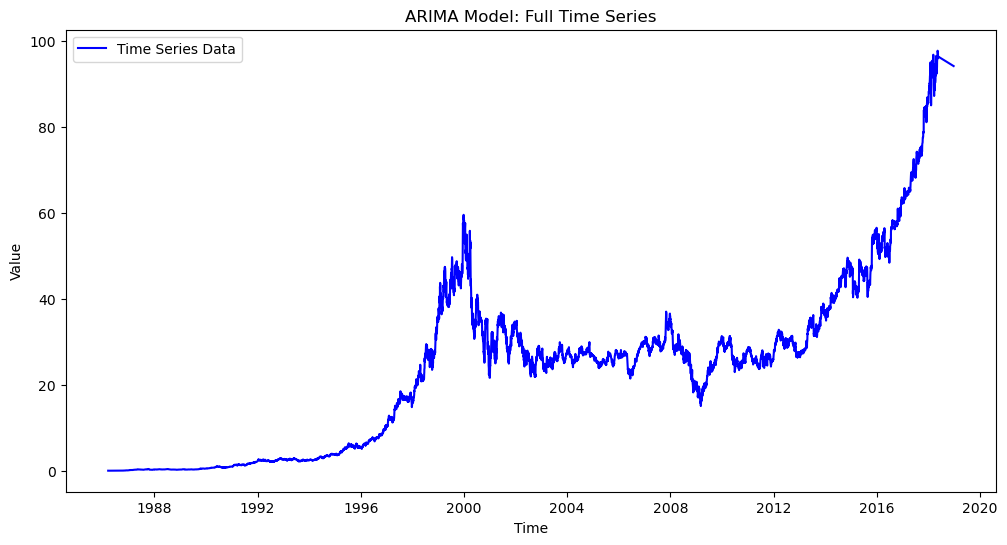

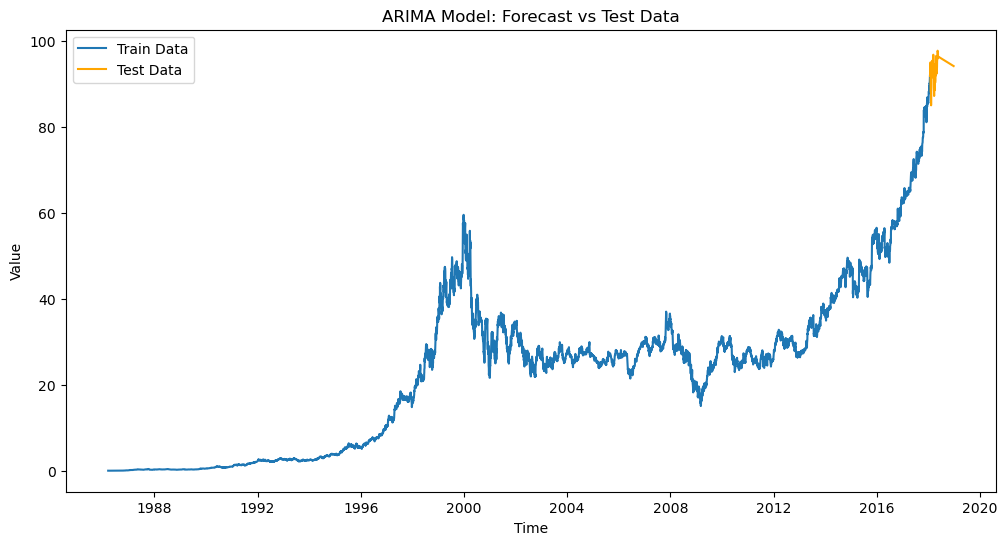

In [46]:
file_path = "my_data/MSFT_cleaned_data.csv"
data = pd.read_csv(file_path, parse_dates=["date"], index_col="date")

data.index = pd.to_datetime(data.index)

time_series = data["close_msft"]
data = data.asfreq('A') 
train = time_series[:-80]
test = time_series[-80:]

model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()

plt.figure(figsize=(12, 6))
plt.plot(time_series, label="Time Series Data", linestyle='-', color='blue')  # Ensure solid line
plt.title("ARIMA Model: Full Time Series")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(train, label="Train Data")
plt.plot(test, label="Test Data", color="orange")
plt.title("ARIMA Model: Forecast vs Test Data")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()

1. **Forecasting**:
   - `predicted_values = model_fit.forecast(steps=len(test))`: Forecasts future values for the test set using the trained ARIMA model.

2. **Evaluating Model Performance**:
   - `aapl = mean_squared_error(test, predicted_values)`: Calculates the Mean Squared Error (MSE) between the actual test values and the predicted values.
   - `r2 = r2_score(test, predicted_values)`: Computes the R-squared value, indicating how well the model fits the data.
   - `adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)`: Adjusts the R-squared for the number of predictors (degrees of freedom) to avoid overfitting.

3. **Saving Results**:
   - `results_df`: A DataFrame with actual vs predicted values for the test set.
   - `metrics_df`: A DataFrame containing the evaluation metrics (MSE, R-squared, Adjusted R-squared).
   - The results are saved to `ARIMA_AAPL_results.csv` for future reference.


In [47]:
predicted_values2 = model_fit.forecast(steps=len(test))

mse = mean_squared_error(test, predicted_values2)
r2 = r2_score(test, predicted_values2)

n = len(test)
p = 1
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f"Mean Squared Error (MSFT): {mse:.2f}")
print(f"R-squared: {r2:.4f}")
print(f"Adjusted R-squared: {adjusted_r2:.4f}")

results_df = pd.DataFrame({
    'Date': test.index,
    'Actual': test.values,
    'Predicted': predicted_values2
})

metrics_df = pd.DataFrame({
    'Metric': ['Mean Squared Error', 'R-squared', 'Adjusted R-squared'],
    'Value': [mse, r2, adjusted_r2]
})

with open('ARIMA_MSFT_results.csv', 'w') as f:

    results_df.to_csv(f, index=False)
    f.write("\n\n")
    metrics_df.to_csv(f, index=False)

Mean Squared Error (MSFT): 7.89
R-squared: -0.2306
Adjusted R-squared: -0.2464
